In [1]:
import numpy as np
from openparticle.fock import FockState
from openparticle.particleoperator import ParticleOperator, FermionOperator, BosonOperator, AntifermionOperator
from typing import Union, List
from symmer.utils import tensor_list
from symmer import PauliwordOp as Pauli
from symmer import QuantumState
from openparticle.qubit_mappings import *


def jordan_wigner(op: Union[FermionOperator, 
                            AntifermionOperator, ParticleOperator], display_latex: bool = False):


    if isinstance(op, (FermionOperator, AntifermionOperator, ParticleOperator)):
        qubit_op_string = ''

        qubit_op_list = ['X' + 'Z' * op.modes[0], 
                         'Y' + 'Z' * op.modes[0]]
        

        if op.ca_string == 'c':
            coeffs = [1/2, -1j/2]
            qubit_op_string = '$' + str(0.5) + qubit_op_list[0] + ' - 0.5' + 'i' + qubit_op_list[1] + '$'
        elif op.ca_string == 'a': 
            coeffs = [1/2, 1j/2]
            qubit_op_string = '$' + str(0.5) + qubit_op_list[0] + ' + 0.5' + 'i' + qubit_op_list[1] + '$'


        if display_latex: display(Latex(qubit_op_string))
        return Pauli.from_list(qubit_op_list, coeffs)
        
    else: raise Exception("The Jordan Wigner mapping only works for fermions and antifermions")

def unary(op: Union[BosonOperator, ParticleOperator], max_bose_mode_occ: int, display_latex: bool = False):

    # assert op.modes[0] <= total_modes

    if isinstance(op, BosonOperator):
        p = op.modes[0]

        Mb = max_bose_mode_occ

        pauli_list = []
        coeffs_list = []
        nq_max = (p + 1) * (Mb + 1) 

        op_str = ''

        for j in range(0, Mb):
            q = (Mb + 1) * p + j
            qubit_diff = nq_max - q - 2
            pauli_list += ["I" * qubit_diff + 'XX' + 'I' * q,
                           "I" * qubit_diff + 'XY' + 'I' * q,
                            "I" * qubit_diff + 'YX' + 'I' * q,
                            "I" * qubit_diff + 'YY' + 'I' * q]
            pauli_list_static = ["I" * qubit_diff + 'XX' + 'I' * q,
                           "I" * qubit_diff + 'XY' + 'I' * q,
                            "I" * qubit_diff + 'YX' + 'I' * q,
                            "I" * qubit_diff + 'YY' + 'I' * q]
            if op.ca_string == 'c':
                coeffs_list += list(np.sqrt(j + 1) / 4 * np.array([1, 1j, -1j, 1]))
                op_str += str(round(np.sqrt(j + 1)/4, 3)) + pauli_list_static[0] + " + " + str(round(np.sqrt(j + 1)/4, 3)) + "i" +  pauli_list_static[1] +\
                      " - " + str(round(np.sqrt(j + 1)/4, 3)) + "i" + pauli_list_static[2] + " + " + str(round(np.sqrt(j + 1)/4, 3)) + pauli_list_static[3] + " +"
            elif op.ca_string == 'a':
                coeffs_list += list(np.sqrt(j + 1) / 4 * np.array([1, -1j, 1j, 1]))
                op_str += str(round(np.sqrt(j + 1)/4, 3)) + pauli_list_static[0] + " - " + str(round(np.sqrt(j + 1)/4, 3)) + "i" +  pauli_list_static[1] +\
                      " + " + str(round(np.sqrt(j + 1)/4, 3)) + "i" + pauli_list_static[2] + " + " + str(round(np.sqrt(j + 1)/4, 3)) + pauli_list_static[3] + " +"

        op = Pauli.from_list(pauli_list, coeffs_list)
        if display_latex: 
            op_str = "$" + op_str[:-1] + "$"
            display(Latex(op_str))

        return op

    else: raise NotImplemented    

def qubit_op_mapping(op: Union[ParticleOperator, FermionOperator, AntifermionOperator, BosonOperator], 
                  max_bose_mode_occ: int = None, total_modes: int = None):
    
    if isinstance(op, FermionOperator): return jordan_wigner(op)
    elif isinstance(op, AntifermionOperator): return jordan_wigner(op)
    elif isinstance(op, BosonOperator): 
        if max_bose_mode_occ == None: raise Exception("Must provide maximum bosonic mode occupancy")
        else: return unary(op, max_bose_mode_occ)

    elif isinstance(op, ParticleOperator):
        if op.fermion_modes != []:
            fermion_qubit = Pauli.from_list(['I' * (max(op.fermion_modes) + 1)], [1])
        else: fermion_qubit = Pauli.empty()
        if op.antifermion_modes != []:
            antifermion_qubit = Pauli.from_list(['I' * (max(op.antifermion_modes) + 1)], [1])
        if op.boson_modes != []:
            boson_qubit = Pauli.from_list(['I'  * ((max(op.boson_modes) + 1) * (max_bose_mode_occ + 1))], [1])
    
        ops_to_tensor = []
        for element in op.input_string.split(" "):
            if element[0] == 'b':
                fermion_qubit *= jordan_wigner(FermionOperator(element[1:]))
            elif element[0] == 'd':
                antifermion_qubit *= jordan_wigner(AntifermionOperator(element[1:]))
            elif element[0] == 'a':
                boson_qubit *= unary(BosonOperator(element[1:]), max_bose_mode_occ)

        if 'fermion_qubit' in vars():
            ops_to_tensor.append(fermion_qubit)
        if 'antifermion_qubit' in vars():
            ops_to_tensor.append(antifermion_qubit)
        if 'boson_qubit' in vars():
            ops_to_tensor.append(boson_qubit)
        

        return tensor_list(ops_to_tensor)


In [2]:
jordan_wigner(FermionOperator('1^'))

 0.500+0.000j XZ +
-0.000-0.500j YZ

In [57]:
def qubit_op_mapping2(op: Union[ParticleOperator, FermionOperator, AntifermionOperator, BosonOperator], 
                  max_bose_mode_occ: int = None, total_modes: int = None):
    
    if isinstance(op, FermionOperator): return jordan_wigner(op)
    elif isinstance(op, AntifermionOperator): return jordan_wigner(op)
    elif isinstance(op, BosonOperator): 
        if max_bose_mode_occ == None: raise Exception("Must provide maximum bosonic mode occupancy")
        else: return unary(op, max_bose_mode_occ)

    elif isinstance(op, ParticleOperator):
        if op.fermion_modes != []:
            fermion_qubit = Pauli.from_list(['I' * (max(op.fermion_modes) + 1)], [1])
        else: fermion_qubit = Pauli.empty()
        if op.antifermion_modes != []:
            antifermion_qubit = Pauli.from_list(['I' * (max(op.antifermion_modes) + 1)], [1])
        if op.boson_modes != []:
            boson_qubit = Pauli.from_list(['I'  * ((max(op.boson_modes) + 1) * (max_bose_mode_occ + 1))], [1])
    
        ops_to_tensor = []
        for element in op.input_string.split(" "):
            if element[0] == 'b':
                fermion_qubit *= jordan_wigner(FermionOperator(element[1:]), max(op.fermion_modes) + 1)
            elif element[0] == 'd':
                antifermion_qubit *= jordan_wigner(AntifermionOperator(element[1:]), max(op.antifermion_modes) + 1)
            elif element[0] == 'a':
                boson_qubit *= unary(BosonOperator(element[1:]), max_bose_mode_occ, max(op.boson_modes))

        if 'fermion_qubit' in vars():
            ops_to_tensor.append(fermion_qubit)
        if 'antifermion_qubit' in vars():
            ops_to_tensor.append(antifermion_qubit)
        if 'boson_qubit' in vars():
            ops_to_tensor.append(boson_qubit)
        

        return tensor_list(ops_to_tensor)

In [58]:
qubit_op_mapping2(ParticleOperator('b0^ b2 a0'), 3)

 0.062-0.000j XZXIIXX +
 0.000-0.062j XZXIIXY +
 0.000+0.062j XZXIIYX +
 0.062-0.000j XZXIIYY +
-0.000-0.062j XZYIIXX +
-0.062-0.000j XZYIIXY +
 0.062-0.000j XZYIIYX +
-0.000-0.062j XZYIIYY +
 0.000+0.062j YZXIIXX +
 0.062-0.000j YZXIIXY +
-0.062+0.000j YZXIIYX +
 0.000+0.062j YZXIIYY +
 0.062-0.000j YZYIIXX +
 0.000-0.062j YZYIIXY +
 0.000+0.062j YZYIIYX +
 0.062-0.000j YZYIIYY +
 0.088-0.000j XZXIXXI +
 0.000-0.088j XZXIXYI +
 0.000+0.088j XZXIYXI +
 0.088-0.000j XZXIYYI +
-0.000-0.088j XZYIXXI +
-0.088-0.000j XZYIXYI +
 0.088-0.000j XZYIYXI +
-0.000-0.088j XZYIYYI +
 0.000+0.088j YZXIXXI +
 0.088-0.000j YZXIXYI +
-0.088+0.000j YZXIYXI +
 0.000+0.088j YZXIYYI +
 0.088-0.000j YZYIXXI +
 0.000-0.088j YZYIXYI +
 0.000+0.088j YZYIYXI +
 0.088-0.000j YZYIYYI +
 0.108-0.000j XZXXXII +
 0.000-0.108j XZXXYII +
 0.000+0.108j XZXYXII +
 0.108-0.000j XZXYYII +
-0.000-0.108j XZYXXII +
-0.108-0.000j XZYXYII +
 0.108-0.000j XZYYXII +
-0.000-0.108j XZYYYII +
 0.000+0.108j YZXXXII +
 0.108-0.000j YZ

In [229]:
qubit_op = jordan_wigner(ParticleOperator('b3^'))
qubit_op_2 = jordan_wigner(ParticleOperator('b0'))
qubit_op_2 = qubit_op_2.tensor(Pauli.from_list(['I' * (qubit_op.n_qubits - qubit_op_2.n_qubits)], [1]))
qubit_op * qubit_op_2

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

 0.500+0.000j IZZZ +
-0.500+0.000j ZZZZ

In [9]:
def map_bose_occ(occupancy_list, N):
    q_bos = []
    for occ in occupancy_list:
        for i in range(N + 1):
            q_bos.append(0 if i == occ else 1)

    return q_bos

In [115]:
def map_fermions_to_qubits(state):
    if state.f_occ != []:       
        fock_list = state.f_occ
        qubit_state = [0] * (state.f_occ[-1] + 1)

        for index in fock_list:
            qubit_state[index] = 1
        return QuantumState([qubit_state[::-1]])

    else: return []

In [116]:
map_fermions_to_qubits(FockState([2], [], []))

[0, 0, 1]


 1.000+0.000j |100>

In [117]:
def map_fermions_to_qubits(state):
    if state.af_occ != []:       
        fock_list = state.af_occ
        qubit_state = [0] * (state.af_occ[-1] + 1)

        for index in fock_list:
            qubit_state[index] = 1
        return qubit_state[::-1]

    else: return []

In [239]:
unary(BosonOperator('0'), 3)

<IPython.core.display.Latex object>

 0.250+0.000j IIXX +
 0.000-0.250j IIXY +
 0.000+0.250j IIYX +
 0.250+0.000j IIYY +
 0.354+0.000j IXXI +
 0.000-0.354j IXYI +
 0.000+0.354j IYXI +
 0.354+0.000j IYYI +
 0.433+0.000j XXII +
 0.000-0.433j XYII +
 0.000+0.433j YXII +
 0.433+0.000j YYII

In [211]:
unary(BosonOperator('1^'), 3)

<IPython.core.display.Latex object>

In [209]:
jordan_wigner(ParticleOperator('b3^'))

<IPython.core.display.Latex object>

In [134]:
(BosonOperator('0^') * FockState([],[],[(0, 2)])).display()

<IPython.core.display.Latex object>

In [144]:
unary(BosonOperator('0^'), 6) * symmer.QuantumState([0, 0, 0, 0, 1, 0, 0])

 1.732+0.000j |0001000>

In [34]:
p = 5
total_modes = 10
ca_string = 'c'


if ca_string == 'c':
    coeffs = [1/2, -1j/2]
elif ca_string == 'a': 
    coeffs = [1/2, 1j/2]

## define symplectic matrix
symp_matrix = np.zeros((2, 2*total_modes), dtype = bool)
symp_matrix[:, -p+1:] = True

## set X term at p
symp_matrix[0, total_modes-p] = True

## set Y term at p
symp_matrix[1, total_modes-p] = True
symp_matrix[1, total_modes + total_modes-p] = True

symmer.PauliwordOp(symp_matrix, np.array(coeffs))

 0.500+0.000j IIIIIXZZZZ +
-0.000-0.500j IIIIIYZZZZ

 0.500+0.000j IIIIIIIXZZ +
-0.000-0.500j IIIIIIIYZZ

In [72]:
x_qubit, qubit_op

( 1.000+0.000j |1101>,
  0.500+0.000j XZZ +
 -0.000-0.500j YZZ)

In [ ]:
class QubitState(symmer.QuantumState):

    def __init__(self, fock_state, encoding_scheme: str = 'jordan_wigner'):
        if encoding_scheme == 'jordan_wigner':
            self.qubit_state = jordan_wigner(fock_state)

    

In [29]:
def qubit_state_mapping(state, max_bose_mode_occ: int = None):

    q_fermi = map_fermions_to_qubits(state)
    q_antifermi = map_antifermions_to_qubits(state)
    q_bos = state.b_occ
    #q_bos = map_bose_occ(state.bos_occupancy, max_bose_mode_occ)#[::-1]
    
    return symmer.QuantumState([q_fermi + q_antifermi + q_bos])

In [1]:
from QCD.hadron import Hadron
from QCD.get_quantum_nums import *

In [42]:
K = 4
Lambda_perp = 0
P_perp = 0

In [43]:
qnums = get_quantum_numbers(K, Lambda_perp)
qnums

,Helicity,n,n⟂
0,+1,0.5,0
1,+1,1.0,0
2,+1,1.5,0
3,+1,2.0,0
4,+1,2.5,0
5,+1,3.0,0
6,+1,3.5,0
7,+1,4.0,0
8,-1,0.5,0
9,-1,1.0,0


In [44]:
pion = Hadron('meson', K)
pion.display()

<IPython.core.display.Latex object>

In [45]:
pion_fock = pion.get_states(K, P_perp, Lambda_perp)
pion_fock.display()
print(len(pion_fock.states_list))

<IPython.core.display.Latex object>

187


In [39]:
import matplotlib.pyplot as plt

In [60]:
K = 4
Lambda_perp = 1

K_list = np.arange(1, K + 1)
num_states = []
for k in K_list:
    pion = Hadron('meson', k)
    num_states.append(len(pion.get_states(k, P_perp, Lambda_perp).states_list))


KeyboardInterrupt: 

Text(0.5, 1.0, 'Number of states for given K at $\\Lambda_\\perp = 0$')

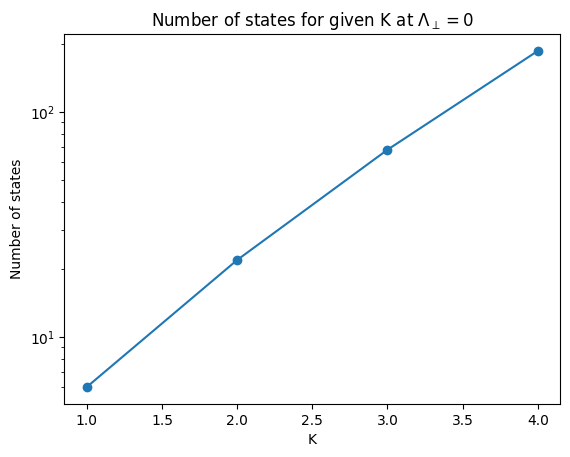

In [59]:

plt.semilogy(K_list, num_states, 'o-')
plt.xlabel('K')
plt.ylabel('Number of states')
plt.title(r"Number of states for given K at $\Lambda_\perp = {}$".format(Lambda_perp))

In [19]:
#SU(2) Flavor matrices

f1 = np.array([[0, 1], [1, 0]])
f2 = np.array([[0, -1j], [1j, 0]])
f3 = np.array([[1, 0], [0, -1]])

#Isospin
T = 1/2 * np.array([f1, f2, f3])
Tsq = T[0].dot(T[0]) + T[1].dot(T[1]) + T[2].dot(T[2])

In [ ]:
u = np.array([[1, 0]]).reshape(-1, 1)
d = np.array([[0, 1]]).reshape(-1, 1)

In [ ]:
np.allclose(T[2].dot(u), 1/2 * u)

In [ ]:
np.allclose(Tsq.dot(u), 1/2 * (1/2 + 1) * u)

In [ ]:
#Ladder operators 
Tplus = T[0] + 1j * T[1]
Tminus = T[0] - 1j * T[1]

In [ ]:
np.allclose(Tplus.dot(u), 0), np.allclose(Tplus.dot(d), u), np.allclose(Tminus.dot(d), 0), np.allclose(Tminus.dot(u), d)

### Color SU(3) Singlets

In [ ]:
lam = np.array([np.array([[0, 1, 0],
                    [1, 0, 0],
                    [0, 0, 0]]),
            np.array([[0, -1j, 0],
                    [1j, 0, 0],
                    [0, 0, 0]]),
            np.array([[1, 0, 0],
                    [0, -1, 0],
                    [0, 0, 0]]),
            np.array([[0, 0, 1],
                    [0, 0, 0],
                    [1, 0, 0]]),
            np.array([[0, 0, -1j],
                    [0, 0, 0],
                    [1j, 0, 0]]),
            np.array([[0, 0, 0],
                    [0, 0, 1],
                    [0, 1, 0]]),
            np.array([[0, 0, 0],
                    [0, 0, -1j],
                    [0, 1j, 0]]),  
            np.array([[1/np.sqrt(3), 0, 0],
                    [0, 1/np.sqrt(3), 0],
                    [0, 0, -2/np.sqrt(3)]])

])
T = lam/2

In [ ]:
r = np.array([1, 0, 0]).reshape(-1, 1)
g = np.array([0, 1, 0]).reshape(-1, 1)
b = np.array([0, 0, 1]).reshape(-1, 1)